# Dreem Sleep Stage Classification Challenge


In [172]:
import pandas as pd
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import random
import pickle

# Import functions made to create features
import get_features 

from tsfresh.feature_extraction.feature_calculators import *
from statsmodels.tsa.stattools import acf

# Features selection
from sklearn.feature_selection import RFE

# Classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, ElasticNet
from sklearn.svm import SVC,LinearSVC
import xgboost as xgb

# Features and data selection
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Score calculation
from sklearn.metrics import f1_score

## Reading data

In [2]:
#  dictionary label: sleep stage
sleeping_labels = {0: "Awake",
                   1: "N1 - light sleep 1",
                   2: "N2 - light sleep 2",
                   3: "N3 - Deep sleep",
                   4: "REM - paradoxical sleep"
                   }
print("Sleeping labels:", sleeping_labels)

Sleeping labels: {0: 'Awake', 1: 'N1 - light sleep 1', 2: 'N2 - light sleep 2', 3: 'N3 - Deep sleep', 4: 'REM - paradoxical sleep'}


In [21]:
# Reading X_train file
file_train = h5py.File('train.h5', 'r')
components_train = list(file_train.keys())
print("Components train:", components_train)
no_components_train = len(components_train)
no_signals_train = len(file_train['accelerometer_x'])
print("- The TRAIN dataset contains {} signals, each one of {} components "
      .format(no_signals_train, no_components_train))

Components train: ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'pulse_oximeter_infrared']
- The TRAIN dataset contains 38289 signals, each one of 11 components 


In [252]:
# Reading Y_train file
Y_train = pd.read_csv("train_y.csv")
Y_train = Y_train.set_index("id")
Y_train.shape

(38289, 1)

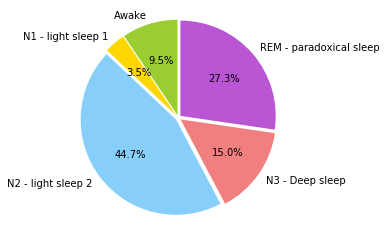

In [20]:
# Distribution
train_labels, counter_train = np.unique(Y_train, return_counts=True)
labels_names = np.array([sleeping_labels[label] for label in train_labels])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=labels_names, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)   # shadow=True

plt.axis('equal')
plt.savefig('lables_pie.png')
plt.show()

> We can observe that the training data provided is out of balance: class 1 is under reprenseted whereas class 2 is over represented
<br> 
Later, we will try to rebalance the training data.

In [67]:
# Reading X_test file
file_test = h5py.File('test.h5', 'r')
components_test = list(file_test.keys())
no_components_test = len(components_test)
no_signals_test = len(file_test['accelerometer_x'])
print("- The TEST dataset contains {} signals, each one of {} components "
      .format(no_signals_test, no_components_test))

- The TEST dataset contains 37439 signals, each one of 11 components 


## First study over 1000 rows

Since we have a big amount of data, we will first randomly choose 1000 rows and make a first study of it (generate features then apply some models on it) before runing our script over the hole data set.

In [8]:
# Pick randomly 'n_sample' rows to work on 
n_sample = 1000
sample_random_integers = random.sample(range(0, no_signals_train), n_sample)

In [9]:
# New dataset of 'n_sample' rows
data_frame_train = pd.DataFrame(columns=components_train + ['y'])
for i, row in tqdm.tqdm(enumerate(sample_random_integers)):
    row_to_add = []
    for acc in components_train:
        row_to_add.append(file_train[acc][row])
    row_to_add.append(y_train["sleep_stage"][row])
    data_frame_train.loc[i] = row_to_add

data_frame_train.head() 

1000it [18:04,  1.09s/it]


,accelerometer_x,accelerometer_y,accelerometer_z,eeg_1,eeg_2,eeg_3,eeg_4,eeg_5,eeg_6,eeg_7,pulse_oximeter_infrared,y
0,"[-0.001010961925116044, -0.0008709274783699189...","[-0.0008303592753357014, 0.0003955117721179383...","[-0.0006081525802563714, 0.0003193188473665764...","[1.7460901105778248, 6.6333117278106215, 5.564...","[9.758054552922658, 11.861015585305609, 0.9978...","[-8.011964437840362, -5.227703882808612, 4.566...","[-12.556294776065442, 1.407722349094911, 16.61...","[-13.383307408229825, 1.3141616160588683, 14.6...","[-14.301662904174918, -5.226460691884313, 11.0...","[-5.3715469502133715, 6.54173491498517, 10.110...","[292.51296614157036, 264.54612813517457, 235.6...",2
1,"[-0.0011150877576990553, -0.001059626278819813...","[-0.0014658992202229992, -0.001157979078203808...","[-0.001129233034376509, -0.001264582570805195,...","[-8.4200356619192, -11.866860923536706, -16.92...","[-10.08104323325756, -14.932827823047546, -13....","[1.6610075341945105, 3.0659668336670904, -3.68...","[-4.376824875487728, -4.5088517635413154, -4.6...","[16.422060735048035, 11.20649986108765, 6.7516...","[4.044627262771428, 7.358120242281075, 12.3017...","[14.761022189133655, 8.141266499435005, 10.438...","[-67.00096081895754, -98.69828239688647, -69.4...",2
2,"[-0.0003740783131077341, 0.0001206443304986307...","[0.0005982594537170538, 0.0002436822051765656,...","[-0.00020898031436500375, 3.595423439517476e-0...","[4.159514433489477, -3.0568964719499263, 3.796...","[-10.551832592425427, -21.11874693727927, -9.0...","[14.711380573104066, 18.061837491104825, 12.89...","[-1.3265187977954156, -13.764690030023075, -13...","[-10.058509534924156, -22.67145316710821, -21....","[-5.486141778053479, -10.707734512968273, -17....","[-24.770003768487527, -40.73313447642147, -34....","[-112.17657332145609, -303.9342951665166, -394...",0
3,"[-0.00031387972022806077, -0.00059001357086413...","[0.00021067129237473115, 0.0001925768770065785...","[-0.0007789081999944325, -0.000564703759256879...","[-2.740960633806935, -4.818322129044191, -8.19...","[3.852719565806183, 5.408333641793888, 11.0475...","[-6.593862992153845, -10.226738224049768, -19....","[8.481296014468171, -24.375038448756186, -50.2...","[13.127683125799877, 1.7468579191438494, -21.4...","[11.221866034450613, -19.555153241509288, -42....","[19.722308193286153, 11.972923835184702, -2.19...","[-103.34836360218469, -90.83823229931298, -82....",1
4,"[-0.0012175743947619722, -0.00222171866902912,...","[-0.0015322259638904656, -0.001172735153814442...","[-0.001803128406751231, -0.002646400354915589,...","[-6.089357099463086, 0.8079440810780625, 3.023...","[27.002846251052347, 24.89148368493636, 30.533...","[-33.0922033420205, -24.08353964957405, -27.50...","[-44.0497318147618, -49.42305765387209, -31.34...","[-25.35061104628403, -7.394833630269204, -24.1...","[-37.960898832461226, -50.23162025082138, -34....","[7.741368664862421, 16.688595793168133, 3.3393...","[-35.49021180975251, -47.34878553356977, -37.4...",4


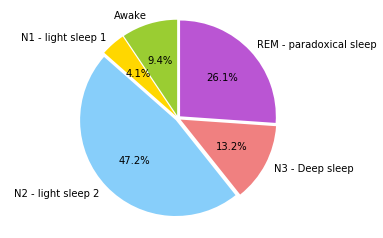

In [10]:
# Distribution of the sample
train_labels, counter_train = np.unique(data_frame_train['y'], return_counts=True)
labels_names = np.array([sleeping_labels[label] for label in train_labels])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=labels_names, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)   # shadow=True

plt.axis('equal')
plt.savefig('lables_pie.png')
plt.show()

We notice that we have here a similar distribution of classes

In [11]:
# Add a last column with original index
data_frame_train['random_choice'] = sample_random_integers
data_frame_train.head() 

,accelerometer_x,accelerometer_y,accelerometer_z,eeg_1,eeg_2,eeg_3,eeg_4,eeg_5,eeg_6,eeg_7,pulse_oximeter_infrared,y,random_choice
0,"[-0.001010961925116044, -0.0008709274783699189...","[-0.0008303592753357014, 0.0003955117721179383...","[-0.0006081525802563714, 0.0003193188473665764...","[1.7460901105778248, 6.6333117278106215, 5.564...","[9.758054552922658, 11.861015585305609, 0.9978...","[-8.011964437840362, -5.227703882808612, 4.566...","[-12.556294776065442, 1.407722349094911, 16.61...","[-13.383307408229825, 1.3141616160588683, 14.6...","[-14.301662904174918, -5.226460691884313, 11.0...","[-5.3715469502133715, 6.54173491498517, 10.110...","[292.51296614157036, 264.54612813517457, 235.6...",2,899
1,"[-0.0011150877576990553, -0.001059626278819813...","[-0.0014658992202229992, -0.001157979078203808...","[-0.001129233034376509, -0.001264582570805195,...","[-8.4200356619192, -11.866860923536706, -16.92...","[-10.08104323325756, -14.932827823047546, -13....","[1.6610075341945105, 3.0659668336670904, -3.68...","[-4.376824875487728, -4.5088517635413154, -4.6...","[16.422060735048035, 11.20649986108765, 6.7516...","[4.044627262771428, 7.358120242281075, 12.3017...","[14.761022189133655, 8.141266499435005, 10.438...","[-67.00096081895754, -98.69828239688647, -69.4...",2,32720
2,"[-0.0003740783131077341, 0.0001206443304986307...","[0.0005982594537170538, 0.0002436822051765656,...","[-0.00020898031436500375, 3.595423439517476e-0...","[4.159514433489477, -3.0568964719499263, 3.796...","[-10.551832592425427, -21.11874693727927, -9.0...","[14.711380573104066, 18.061837491104825, 12.89...","[-1.3265187977954156, -13.764690030023075, -13...","[-10.058509534924156, -22.67145316710821, -21....","[-5.486141778053479, -10.707734512968273, -17....","[-24.770003768487527, -40.73313447642147, -34....","[-112.17657332145609, -303.9342951665166, -394...",0,4993
3,"[-0.00031387972022806077, -0.00059001357086413...","[0.00021067129237473115, 0.0001925768770065785...","[-0.0007789081999944325, -0.000564703759256879...","[-2.740960633806935, -4.818322129044191, -8.19...","[3.852719565806183, 5.408333641793888, 11.0475...","[-6.593862992153845, -10.226738224049768, -19....","[8.481296014468171, -24.375038448756186, -50.2...","[13.127683125799877, 1.7468579191438494, -21.4...","[11.221866034450613, -19.555153241509288, -42....","[19.722308193286153, 11.972923835184702, -2.19...","[-103.34836360218469, -90.83823229931298, -82....",1,22023
4,"[-0.0012175743947619722, -0.00222171866902912,...","[-0.0015322259638904656, -0.001172735153814442...","[-0.001803128406751231, -0.002646400354915589,...","[-6.089357099463086, 0.8079440810780625, 3.023...","[27.002846251052347, 24.89148368493636, 30.533...","[-33.0922033420205, -24.08353964957405, -27.50...","[-44.0497318147618, -49.42305765387209, -31.34...","[-25.35061104628403, -7.394833630269204, -24.1...","[-37.960898832461226, -50.23162025082138, -34....","[7.741368664862421, 16.688595793168133, 3.3393...","[-35.49021180975251, -47.34878553356977, -37.4...",4,11994


In [47]:
# Saving row data

def binary_save(file, path, file_name):
    """Save in binary the Tenders"""
    with open(path + '\\' + file_name, 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(file)

binary_save(data_frame_train, r"C:\Users\Driss Debbagh\Desktop\Cours 3A\Machine Learning\Kaggle\kaggle_holidays", "thousand_rows")

In [150]:
# Reading raw data

def binary_load(path, file_name):
    """Allows to load pickles"""
    with open(path + '\\' + file_name, 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        a_memoriser = mon_depickler.load()
    return a_memoriser

#thousand_rows_data = binary_load("Data", "thousand_rows")

### Generating training features

In [ ]:
#Create driss features
get_features.features_data(thousand_rows_data, list_sensors)

#Create Mike features
get_features.gene_features(thousand_rows_data)

In [17]:
# Merging features
mike_feat = pd.read_excel('thousand/mike_train_thousand.xlsx')
driss_feat = pd.read_csv('thousand/driss_train_thousand.csv', sep=',')

thousand_features = pd.concat([driss_feat,mike_feat.drop('y',axis=1)], axis=1, join_axes=[mike_feat.index])


,Unnamed: 0,ID,max_fft_x_1_accelerometer_x,max_fft_x_2_accelerometer_x,max_fft_x_3_accelerometer_x,max_fft_x_4_accelerometer_x,max_fft_x_5_accelerometer_x,max_fft_y_1_accelerometer_x,max_fft_y_2_accelerometer_x,max_fft_y_3_accelerometer_x,...,Indice_max_autocorr accelerometer_y,Indice_max_autocorr accelerometer_z,Indice_max_autocorr eeg_1,Indice_max_autocorr eeg_2,Indice_max_autocorr eeg_3,Indice_max_autocorr eeg_4,Indice_max_autocorr eeg_5,Indice_max_autocorr eeg_6,Indice_max_autocorr eeg_7,Indice_max_autocorr pulse_oximeter_infrared
0,0,0,0.134228,0.268456,0.402685,0.469799,0.604027,0.000156,0.000346,0.000087,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.067114,0.167785,0.268456,0.335570,0.402685,0.000682,0.001093,0.001474,...,1,1,0,0,0,0,0,0,0,0
2,2,2,0.100671,0.167785,0.234899,0.302013,0.402685,0.000312,0.000242,0.000215,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0.067114,0.167785,0.402685,0.671141,1.006711,0.009545,0.018290,0.007689,...,0,0,0,0,0,0,0,0,0,0
4,4,4,0.134228,0.201342,0.335570,0.436242,0.536913,0.000082,0.000094,0.000062,...,0,0,0,0,0,0,0,0,0,0


### Qualitative analysis of the importance of data

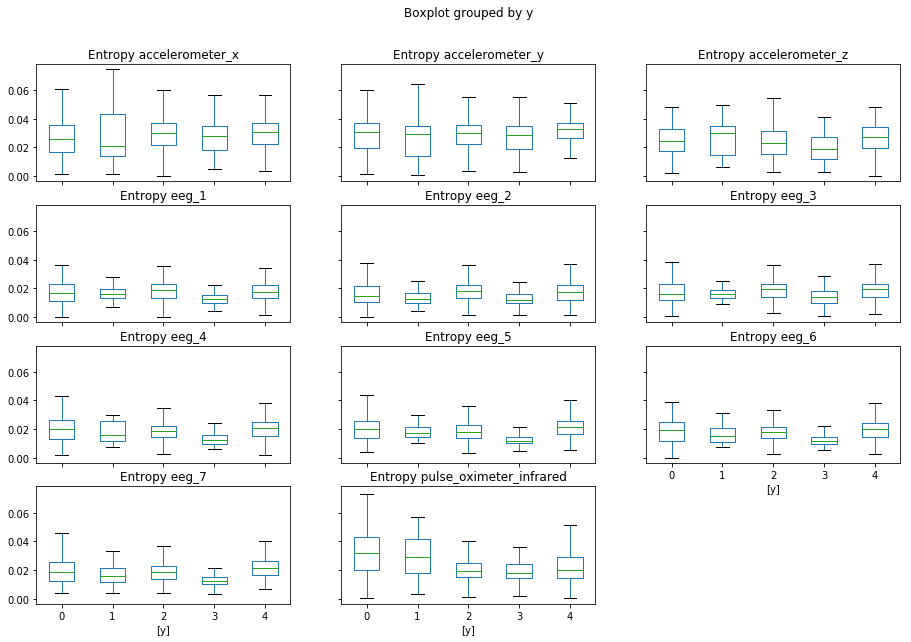

In [18]:
# Boxplots
entropy_features = thousand_features.filter(like="Entropy")
list(entropy_features.columns)
boxplot = thousand_features.boxplot(column=list(thousand_features[entropy_features.columns]), by=['y'], figsize=(15,10), grid=False, showfliers=False)

# Back to the whole dataset

### Generating training features

In [ ]:
#Create driss features
get_features.features_data(file_train, list_sensors)
get_features.features_data(file_test, list_sensors)

#Create Mike features
get_features.gene_features(file_train)
get_features.gene_features(file_test)

### Build some models for classification

In [ ]:
# Features and corresponding labels
X = all_train_features
y = Y_train


#### Sklearn Random Forest with tuning

In [ ]:
# Tuning Random Forest classifier with cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier()
parameters = {'n_estimators':[100,150,200], 'max_features': ['auto','sqrt','log2']}
clf = GridSearchCV(rf, parameters, cv=5)
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test), average = 'macro')

#### Sklearn GradientBoosting with tuning

In [16]:
# Sklearn GradientBoosting
gbc = GradientBoostingClassifier()
parameters = {'n_estimators':[100,150,200], 'max_features': ['auto','sqrt','log2']}
clf = GridSearchCV(gbc, parameters, cv=5)
clf.fit(X_train, y_train)
f1_score(y_test, gbc.predict(X_test), average = 'macro')

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.50120212505288

Not a very good result

#### XgBoost Model 

In [101]:
# XgBoost Model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':6,'num_class':5,'silent': 1, 'objective': 'multi:softmax'}
num_round = 100
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist)
f1_score(y_test, bst.predict(dtest), average = 'macro')

[0]	eval-merror:0.401802	train-merror:0.361105
[1]	eval-merror:0.38117	train-merror:0.33662
[2]	eval-merror:0.371246	train-merror:0.323137
[3]	eval-merror:0.36093	train-merror:0.307172
[4]	eval-merror:0.349047	train-merror:0.296497
[5]	eval-merror:0.343171	train-merror:0.286083
[6]	eval-merror:0.338731	train-merror:0.275309
[7]	eval-merror:0.332071	train-merror:0.267115
[8]	eval-merror:0.326587	train-merror:0.260977
[9]	eval-merror:0.32515	train-merror:0.253958
[10]	eval-merror:0.319796	train-merror:0.246025
[11]	eval-merror:0.316271	train-merror:0.239039
[12]	eval-merror:0.314442	train-merror:0.232216
[13]	eval-merror:0.309611	train-merror:0.227221
[14]	eval-merror:0.30726	train-merror:0.224283
[15]	eval-merror:0.305171	train-merror:0.219712
[16]	eval-merror:0.30034	train-merror:0.214717
[17]	eval-merror:0.30047	train-merror:0.209918
[18]	eval-merror:0.300601	train-merror:0.204695
[19]	eval-merror:0.298381	train-merror:0.199079
[20]	eval-merror:0.296553	train-merror:0.193856
[21]	eval

0.623860293846173

Xgboost gives better results compared with Gradient Boosting but there is still room for improvement
> Let's choose our features in a better way

# Removing Correlated Features

In [19]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X_uncorr = X.drop(to_drop, axis=1)

In [322]:
print('Number of features correlated with other features:',len(to_drop))

Number of features correlated with other features: 67


## Features Selection 

We will use three different methods to select important features only

- Random Forest Features Importance
- ExtraTreeClassifier Feature Importance
- Recursive features elimination

### Random Forest Feature Importance

In [118]:
rnd_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rnd_clf.fit(X_uncorr, y)

df_rf = pd.DataFrame(index=X_uncorr.columns)
df_rf['Imp'] = rnd_clf.feature_importances_

df_rf = df_rf.sort_values(by='Imp',ascending=False)

C:\Users\mehdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### ExtraTreeClassifier Feature Importance

In [119]:
forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=0)

forest.fit(X_uncorr, y)
importances = forest.feature_importances_

importances_dataframe = pd.DataFrame(index=X_uncorr.columns)
importances_dataframe['Importance'] = importances

importances_dataframe = importances_dataframe.sort_values(by='Importance', ascending=False)


C:\Users\mehdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


### Recursive Features Elimination

In [ ]:
# Takes time to run !!!
estimator = GradientBoostingClassifier(n_estimators = 100, max_depth = 5)
selector = RFE(estimator, 20, step=1)
selector = selector.fit(X, y)

In [ ]:
try:
    df = pd.DataFrame(index=X.columns)
    df['Importance'] = selector.ranking_
    df = df.sort_values(by='Importance')
except:
    df = pd.read_excel('feat_imp_recur.xlsx')
X_bis_rec = X.drop(df.index[20:],axis=1)

### Merging selected features and building new dataset of features

We keep the 60 first important features got from the three methods

In [151]:
nbr_feat = 60
X_duo = X_uncorr[np.unique(np.concatenate([df_rf.index[0: nbr_feat], importances_dataframe.index[0: nbr_feat]
                                           ]))] 


### Finding Optimal Parameters

In [165]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax',
                    silent=True, nthread=1)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [10, 15, 20]
        }
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, 
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X_duo,y), verbose=3, random_state=1001 )



### Build some models for classification

#### Training an Xgboost Model

In [124]:
# Split data to train and test using new dataset of features
X_train, X_test, y_train, y_test = train_test_split(X_duo, y, test_size=0.2)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':6,'num_class':5,#'colsample_bytree':0.7,'eta': 0.3,'min_child_weigh':7,
         'silent': 1, 'objective': 'multi:softmax'}
num_round = 100
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist)
f1_score(y_test, bst.predict(dtest), average = 'macro')

[0]	eval-merror:0.380909	train-merror:0.335804
[1]	eval-merror:0.358318	train-merror:0.308903
[2]	eval-merror:0.344476	train-merror:0.288792
[3]	eval-merror:0.337294	train-merror:0.273514
[4]	eval-merror:0.329982	train-merror:0.261794
[5]	eval-merror:0.324628	train-merror:0.253567
[6]	eval-merror:0.320319	train-merror:0.242891
[7]	eval-merror:0.314834	train-merror:0.23251
[8]	eval-merror:0.309611	train-merror:0.222258
[9]	eval-merror:0.307913	train-merror:0.216121
[10]	eval-merror:0.303343	train-merror:0.20711
[11]	eval-merror:0.300731	train-merror:0.200287
[12]	eval-merror:0.297728	train-merror:0.193758
[13]	eval-merror:0.29381	train-merror:0.186543
[14]	eval-merror:0.290546	train-merror:0.180046
[15]	eval-merror:0.28702	train-merror:0.172897
[16]	eval-merror:0.284408	train-merror:0.168881
[17]	eval-merror:0.282189	train-merror:0.163429
[18]	eval-merror:0.281927	train-merror:0.158271
[19]	eval-merror:0.278924	train-merror:0.153864
[20]	eval-merror:0.278532	train-merror:0.150338
[21]	e

0.6348825900902257

> We observe that we have a better score than the one before but we might overfit because of the number of estimators chosen (num_round)
Let's try to merge predictions from different classfiers

### Voting Classifier

In [114]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

clf2 = RandomForestClassifier(n_estimators=100, random_state=1,max_depth= 5)
clf3 = GradientBoostingClassifier(n_estimators = 100, max_depth = 5)
clf4 = xgb.XGBClassifier(n_estimators=100, objective='multi:softmax', silent=True, nthread=1)
eclf1 = VotingClassifier(estimators=[ ('rf', clf2), ('gb', clf3), ('xgb',clf4)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)


eclf1 = VotingClassifier(estimators=[ ('rf', clf2), ('gb', clf3), ('xgb',clf4)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
f1_score(y_test, eclf1.predict(X_test), average = 'macro')

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As notified before, our training dataset is unbalanced. Let us now rebalance it and see what happens.

## Rebalancing the dataset

In [22]:
all_train_features_labeled = pd.concat([all_train_features, y_train['sleep_stage']],
                                       axis=1, join_axes=[all_train_features.index])

class_one_data = all_train_features_labeled[all_train_features_labeled['sleep_stage'] == 1].reset_index()
class_two_data = all_train_features_labeled[all_train_features_labeled['sleep_stage'] == 2].reset_index()
class_three_data = all_train_features_labeled[all_train_features_labeled['sleep_stage'] == 3].reset_index()
class_four_data = all_train_features_labeled[all_train_features_labeled['sleep_stage'] == 4].reset_index()
class_zero_data = all_train_features_labeled[all_train_features_labeled['sleep_stage'] == 0].reset_index()

print(class_one_data.shape)
print(class_two_data.shape)
print(class_three_data.shape)
print(class_four_data.shape)
print(class_zero_data.shape)

(1353, 409)
(17132, 409)
(5731, 409)
(10454, 409)
(3619, 409)


In [23]:
# Duplicate rows of class 1
class_one_data = class_one_data.append([class_one_data] * 1).reset_index()

# Truncate rows of classes two and four
class_two_data = class_two_data.truncate(before=0, after=8000)
class_four_data = class_four_data.truncate(before=0, after=6000)

# class_zero_data = class_zero_data.append([class_zero_data])
# class_zero_data = class_zero_data



In [ ]:
rebalanced_train_data = pd.concat([class_one_data, class_two_data, class_three_data, class_four_data, class_zero_data])
rebalanced_train_data = rebalanced_train_data.sample(frac=1)

# Save the new training features' dataset
rebalanced_train_data.to_csv("rebalanced_train_features.csv")

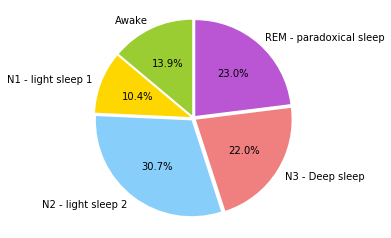

In [26]:
# Distribution of the sample
train_labels_, counter_train = np.unique(rebalanced_train_data['sleep_stage'], return_counts=True)
labels_names = np.array([sleeping_labels[label] for label in train_labels_])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=labels_names, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)   # shadow=True

plt.axis('equal')
plt.savefig('lables_pie.png')
plt.show()

> The distribution is now way more rebalanced

#### Read the new file

In [35]:
X_rebal = pd.read_csv('Data/rebalanced_train_features.csv', sep=',')
y_rebal = X_rebal['sleep_stage']

In [37]:
print(X_rebal.shape)
X_rebal.head()

(26058, 411)


,Unnamed: 0,Abs_Max accelerometer_x,Abs_Max accelerometer_y,Abs_Max accelerometer_z,Abs_Max eeg_1,Abs_Max eeg_2,Abs_Max eeg_3,Abs_Max eeg_4,Abs_Max eeg_5,Abs_Max eeg_6,...,max_psd_y_5_accelerometer_z,max_psd_y_5_eeg_1,max_psd_y_5_eeg_2,max_psd_y_5_eeg_3,max_psd_y_5_eeg_4,max_psd_y_5_eeg_5,max_psd_y_5_eeg_6,max_psd_y_5_eeg_7,max_psd_y_5_pulse_oximeter_infrared,sleep_stage
0,1844,0.004489,0.003931,0.004038,55.874052,85.976135,48.017907,148.344379,145.078893,149.266416,...,6.620000e-08,3.491073e+00,6.965667,3.362594,21.649466,1.115648e+01,2.341354e+01,18.686814,3.675175e+02,3
1,4500,0.001853,0.001344,0.002129,27.564077,29.521212,24.543414,153.746772,638.643249,152.063901,...,8.120000e-08,2.396681e+00,6.268449,0.630637,11.616077,1.563647e+03,9.247094e+00,1569.039621,1.684057e+02,2
2,7679,0.003579,0.002260,0.004125,31.873831,43.837873,26.146709,79.528592,87.086067,68.993529,...,3.790000e-07,3.501312e+00,7.478523,1.605470,20.388373,2.956063e+01,1.750826e+01,23.186547,1.530561e+04,2
3,689,0.495310,0.469402,0.178729,66640.958031,66518.251366,10365.336272,17055.293121,23540.851332,71078.868164,...,5.627900e-04,4.724857e+06,819948.325500,68504.238830,461450.781100,1.175976e+06,5.951839e+06,689599.889800,4.129438e+10,1
4,771,0.050710,0.047964,0.031052,322.272009,383.649300,561.915795,2419.849885,815.852853,2276.796122,...,3.540000e-07,4.477053e+01,9.481689,31.431971,109.487167,1.533272e+02,1.071577e+02,98.613363,2.725052e+02,2


### Features selection

In the same as for original features, we will select only some features to keep.

In [ ]:
# ExtraTrees 
forest_reb = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest_reb.fit(X_rebal, y_rebal)
importances_reb = forest_reb.feature_importances_

importances_dataframe_reb = pd.DataFrame(index=X_rebal.columns)
importances_dataframe_reb['Importance'] = importances_reb

importances_dataframe_reb = importances_dataframe_reb.sort_values(by='Importance', ascending=False)
importances_dataframe_reb.head()

# Random forest
rnd_clf_reb = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
rnd_clf_reb.fit(X_rebal, y_rebal)

df_rf_reb = pd.DataFrame(index=X_rebal.columns)
df_rf_reb['Imp'] = rnd_clf_reb.feature_importances_

df_rf_reb = df_rf_reb.sort_values(by='Imp', ascending=False)


### Merge features and build models

In [17]:
X_duo_rebal = X_rebal[np.unique(np.concatenate([df_rf_reb.index[0:60], importances_dataframe_reb.index[0:60]]))]
#X_trio =X[np.unique(np.concatenate([df_rf.index[0:20],df.index[0:20],importances_dataframe.index[0:20]]))]

X_train, X_test, y_train, y_test = train_test_split(X_duo_rebal, y_rebal, test_size=0.2)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':15,'num_class':5, 'eta': 0.3, 'silent': 1, 'objective': 'multi:softmax'}
num_round = 20
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist)
f1_score(y_test, bst.predict(dtest), average = 'macro')


[0]	eval-merror:0.37452	train-merror:0.099012
[1]	eval-merror:0.334804	train-merror:0.043318
[2]	eval-merror:0.311397	train-merror:0.027583
[3]	eval-merror:0.29528	train-merror:0.018325
[4]	eval-merror:0.287797	train-merror:0.012089
[5]	eval-merror:0.27878	train-merror:0.007771
[6]	eval-merror:0.273024	train-merror:0.005181
[7]	eval-merror:0.268419	train-merror:0.003118
[8]	eval-merror:0.264774	train-merror:0.001919
[9]	eval-merror:0.261512	train-merror:0.001199
[10]	eval-merror:0.259977	train-merror:0.00072
[11]	eval-merror:0.254988	train-merror:0.000528
[12]	eval-merror:0.253837	train-merror:0.000288
[13]	eval-merror:0.251343	train-merror:0.000192
[14]	eval-merror:0.250576	train-merror:0.000144
[15]	eval-merror:0.250959	train-merror:4.8e-05
[16]	eval-merror:0.248081	train-merror:0
[17]	eval-merror:0.245971	train-merror:0
[18]	eval-merror:0.245012	train-merror:0
[19]	eval-merror:0.243285	train-merror:0


0.7633148824637035

> We observe again better results 

## Classification on Test Dataset

### Reading Features of Test dataset

In [218]:
feat_test_mike = pd.read_excel('test_data/mike_test_features_all.xlsx')
feat_test_driss = pd.read_csv('test_data/driss_test_features_all.csv', sep=',')

feat_test_all = pd.concat([feat_test_mike,feat_test_driss], axis=1, join_axes=[feat_test_driss.index])

### Training on the full dataset & generating predictions

In [152]:
# Features selection
feat_to_keep = 200
X_uncorr = feat_test_all.drop(to_drop, axis=1)
X_test_duo = feat_test_all[np.unique(np.concatenate([df_rf.index[0: feat_to_keep], 
                                                     importances_dataframe.index[0: feat_to_keep]]))]

In [154]:
dtrain = xgb.DMatrix(X_duo, label=y)
dtest = xgb.DMatrix(X_test_duo)

param = {'max_depth':8,'num_class':5,#'colsample_bytree':0.7,'eta': 0.3,'min_child_weigh':7,
         'silent': 1, 'objective': 'multi:softmax'}
num_round = 100
#evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round)

In [155]:
# Generate predictions
dtest_to_pred = xgb.DMatrix(X_test_duo)

output = pd.DataFrame(index=X_test_duo.index)
output['id'] = output.index
output['sleep_stage'] = bst.predict(dtest_to_pred).astype('int')


# Generate CSV file to submit
output.to_csv('Predictions/xgboost_100_fs_200.csv',sep=',',index=False)

### Training on the Rebalanced dataset & generating predictions

In [ ]:
# Reading data
X_rebal = pd.read_csv('Data/rebalanced_train_features.csv', sep=',')
y_rebal = X_rebal['sleep_stage']

In [ ]:
# Features selection
nbr_feat = 60
X_duo_rebal = X_rebal[np.unique(np.concatenate([df_rf_reb.index[0:nbr_feat], 
                                                importances_dataframe_reb.index[0:nbr_feat]]))]
#X_trio =X[np.unique(np.concatenate([df_rf.index[0:20],df.index[0:20],importances_dataframe.index[0:20]]))]

In [ ]:
# XgBoost model
dfull = xgb.DMatrix(X_duo_rebal, label=y_rebal)
param = {'max_depth':10,'num_class':5, 'eta': 0.3, 'silent': 1, 'objective': 'multi:softmax'}
num_round = 20

# Training the model
bst = xgb.train(param, dfull, num_round)

In [ ]:
# Generate predictions
dtest_to_pred = xgb.DMatrix(X_test_duo)
output_rebal = pd.DataFrame(index=X_test_duo.index)
output_rebal['sleep_stage'] = bst.predict(dtest_to_pred).astype('int')

# Generate CSV to submit
output_rebal.to_csv('Predictions/pred_rebal.csv', sep=';')

## Comparing predictions

#### XGboost training on full dataset

In [ ]:
train_labels, counter_train = np.unique(output['sleep_stage'], return_counts=True)
labels_names = np.array([sleeping_labels[label] for label in train_labels])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=labels_names, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)
plt.title('XGboost training on full dataset')
plt.axis('equal')
plt.show()

#### XGboost training on 80% of dataset

In [ ]:
z = pd.read_csv('Predictions/pred4.csv', sep=';')

train_labels, counter_train = np.unique(z['sleep_stage'], return_counts=True)
labels_names = np.array([sleeping_labels[label] for label in train_labels])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=labels_names, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)
plt.title('XGboost training on 80% of dataset')
plt.axis('equal')
plt.show()

#### XGboost rebalanced training on full dataset

In [ ]:
z = pd.read_csv('Predictions/pred_rebal.csv', sep=';')

train_labels, counter_train = np.unique(z['sleep_stage'], return_counts=True)
labels_names = np.array([sleeping_labels[label] for label in train_labels])
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "mediumorchid"]
explode = (0.03, 0.03, 0.03, 0.03, 0.03)
plt.pie(counter_train, labels=labels_names, colors=colors, explode=explode,
        autopct='%1.1f%%', startangle=90)
plt.title('XGboost rebalanced training on full dataset')
plt.axis('equal')
plt.show()

# New Features

In this part, we have created new features to rebalance the original distribution of the sleep stages. To do so, we added a normal noise to some of the features from class 0,1 and 3 (the ones that are under represented in the original dataset). 

We are adding in total 3000 rows for class 0, 4000 for class 1 and 2000 for class 3


In [249]:
driss_feat_new_0 = pd.read_csv('driss_features_00.csv')
driss_feat_new_1 = pd.read_csv('driss_features_11.csv')
driss_feat_new_3 = pd.read_csv('driss_features_33.csv')

mike_feat_new_0 = pd.read_excel('new_feat_01.xlsx')
mike_feat_new_0['y'] = 0

mike_feat_new_1 = pd.read_excel('new_feat_11.xlsx')
mike_feat_new_1['y'] = 1

mike_feat_new_3 = pd.read_excel('new_feat_31.xlsx')
mike_feat_new_3['y'] = 3

In [250]:
driss_feat_new = driss_feat_new_0.append(driss_feat_new_1).append(driss_feat_new_3).reset_index(drop=True)
driss_feat_new = driss_feat_new.drop(driss_feat_new.columns[0:3],axis=1)

mike_feat_new = mike_feat_new_0.append(mike_feat_new_1).append(mike_feat_new_3).reset_index(drop=True)
#mike_feat_new = mike_feat_new.drop(mike_feat_new.columns[0],axis=1)

mike_feat_new.to_csv('train_data/mike_train_new.csv')
driss_feat_new.to_csv('train_data/driss_train_new.csv')

In [8]:
# Merging features
mike_feat = pd.read_excel('train_data/mike_train_features_all.xlsx')
driss_feat = pd.read_csv('train_data/driss_train_features_all.csv', sep=',')

all_train_features = pd.concat([driss_feat, mike_feat], axis=1, join_axes=[mike_feat.index])
print("Number of features:", all_train_features.shape[1])

Number of features: 429


In [291]:
# Merging features
mike_feat = pd.read_excel('train_data/mike_train_features_all.xlsx')
driss_feat = pd.read_csv('train_data/driss_train_features_all.csv', sep=',')

all_train_features = pd.concat([driss_feat, mike_feat], axis=1, join_axes=[mike_feat.index])
all_train_features['y'] = Y_train


mike_feat_new = pd.read_csv('train_data/mike_train_new.csv')
driss_feat_new = pd.read_csv('train_data/driss_train_new.csv')

new_col = driss_feat.columns.values[0:60]
anc_col = driss_feat_new.columns.values[1:61]

for i in range(len(anc_col)):
    driss_feat_new = driss_feat_new.rename(columns ={anc_col[i]:new_col[i]})

all_train_features_new = pd.concat([driss_feat_new, mike_feat_new.drop('y',axis=1)], axis=1, join_axes=[mike_feat_new.index])
all_train_features_new = all_train_features_new.drop(all_train_features_new.columns[0],axis=1)

all_train_full = all_train_features.append(all_train_features_new).reset_index(drop=True)


### Trying Xgboost Classifier

In [318]:
# Resampling the dataframe 

sample_train = all_train_full.sample(len(all_train_full)).reset_index(drop=True)
X = sample_train.drop('y',axis=1)
X = X.reindex(sorted(X.columns), axis=1)
y = sample_train['y']


dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(feat_test_all.reindex(sorted(feat_test_all.columns), axis=1))

param = {'max_depth':8,'num_class':5,'silent': 1, 'objective': 'multi:softmax'}
num_round = 100
bst = xgb.train(param, dtrain, num_round)

In [319]:
dtest = xgb.DMatrix(feat_test_all.reindex(sorted(feat_test_all.columns), axis=1))
output = pd.DataFrame(index=feat_test_all.index)
output['id'] = output.index
output['sleep_stage'] = bst.predict(dtest).astype('int')

output.to_csv('Predictions/testo.csv',sep=',',index=False)

#### Generating the prediction file

In [106]:
output = pd.DataFrame(index=feat_test_all.index)
output['id'] = output.index
output['sleep_stage'] = bst.predict(dtest).astype('int')

output.to_csv('Predictions/xgboost_full_feat_500.csv',sep=',',index=False)